# Measuring Learning Outcomes for Pretest and Postest

if action type is 4 or 3 then print that there was the submission of the activity


for every student
for every test
for every row
we want to evaluate how well they did in that activity
- correct or not? is mst
- cost of their solution?
    - normalize by cost-opt cost / cost percentage [check other repo]
- avgerage error in pretest is their preknowledge
- max error
- min error
- future boxplots? for errors 

stage 1: connectedness
    stage2: how costly it was from the original
       


create dictionary of precomputed opt_cost based for every problem

do eval on
1. check if thir solution spans the network (is_spanning property) state.py
2. cost (get_cost function)
    a. normalize: get cost, get the state's graph and get_graph_cost optimal cost 

In [1]:
from justhink_problem.problem import init_problem, reset_problem
from justhink_problem.domain.state import WorldState
import pathlib as pl
import pickle
import pandas as pd
import copy

# Define paths.

In [2]:
processed_tables_pickle_file = pl.Path(
    '../processed_data/processed_tables.pickle')

# Load pickled data.

In [3]:
with processed_tables_pickle_file.open('rb') as handle:
    processed_tables = pickle.load(handle)

In [4]:
processed_tables.keys()

dict_keys([6, 1, 9, 7, 2, 5, 4, 3, 10])

In [39]:
# get the submission rows
# drop the unnecessary columns, keep state, activity, imported info
# drop multiple submission just keep last ones
# compute error for each test for each child

for student, df in processed_tables.items():

    df = df.copy()
    df = df[df['is_submission']]

    df.drop(['Time', 'header.seq', 'state.edges', 'state.suggested.u', 'state.suggested.v', 'state.terminal', 'state.submit_suggested', 'action.type', 'action.edge.u', 'action.edge.v', 'turn_agent', 'next_state.edges', 'next_state.suggested.u', 'next_state.suggested.v',
            'next_state.terminal', 'next_state.submit_suggested', 'action_no', 'step_no'], axis=1, inplace=True)

    # removing duplicate rows from submission log
    df.drop_duplicates(subset="header.frame_id",
                       keep='first', inplace=True)

    # removing collaborative activity rows
    df = df[df['header.frame_id'] != "collab-activity"]
    df = df[df['header.frame_id'] != "collab-activity-2"]

    # adding mst_cost and spanning columns
    mst_costs = []
    spanning = []

    for i, row in df.iterrows():
        mst_costs.append(row['world_state'].get_mst_cost())
        spanning.append(row['world_state'].is_spanning())

    df['mst_cost'] = mst_costs
    df['spanning'] = spanning

    # calculating and adding a normalized error column
    norm_error = []
    for i, row in df.iterrows():

        # computing normalized error
        error = (int(row['cost']) - int(row['mst_cost'])) / \
            int(row['mst_cost'])
        norm_error.append(error)

    df['normalized_error'] = norm_error
    df

    print("STUDENT", student)
    display(df)

STUDENT 6


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
11,pretest-1,human,"WorldState(n:7,e:12|e:7,c:19,s:True,t:False)",True,19,False,15,True,0.266667
21,pretest-2,human,"WorldState(n:7,e:12|e:8,c:46,s:True,t:False)",True,46,False,30,True,0.533333
30,pretest-3,human,"WorldState(n:7,e:12|e:7,c:26,s:True,t:False)",True,26,False,21,True,0.238095
39,pretest-4,human,"WorldState(n:7,e:12|e:7,c:56,s:True,t:False)",True,56,False,45,True,0.244444
48,pretest-5,human,"WorldState(n:7,e:12|e:7,c:19,s:True,t:False)",True,19,False,15,True,0.266667
247,posttest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:False,t:False)",True,15,False,15,False,0.000000
256,posttest-2,human,"WorldState(n:7,e:12|e:7,c:38,s:True,t:False)",True,38,False,30,True,0.266667
265,posttest-3,human,"WorldState(n:7,e:12|e:7,c:26,s:True,t:False)",True,26,False,21,True,0.238095
274,posttest-4,human,"WorldState(n:7,e:12|e:7,c:53,s:True,t:False)",True,53,False,45,True,0.177778
282,posttest-5,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",True,16,False,15,True,0.066667


STUDENT 1


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
11,pretest-1,human,"WorldState(n:7,e:12|e:7,c:23,s:True,t:False)",True,23,False,15,True,0.533333
20,pretest-2,human,"WorldState(n:7,e:12|e:7,c:38,s:True,t:False)",True,38,False,30,True,0.266667
29,pretest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",True,22,False,21,True,0.047619
37,pretest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",True,45,True,45,True,0.000000
45,pretest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
252,posttest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
260,posttest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",True,30,True,30,True,0.000000
268,posttest-3,human,"WorldState(n:7,e:12|e:6,c:21,s:True,t:False)",True,21,True,21,True,0.000000
276,posttest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",True,45,True,45,True,0.000000
284,posttest-5,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",True,16,False,15,True,0.066667


STUDENT 9


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
13,pretest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
28,pretest-2,human,"WorldState(n:7,e:12|e:12,c:78,s:True,t:False)",True,78,False,30,True,1.600000
41,pretest-3,human,"WorldState(n:7,e:12|e:11,c:46,s:True,t:False)",True,46,False,21,True,1.190476
58,pretest-4,human,"WorldState(n:7,e:12|e:12,c:99,s:True,t:False)",True,99,False,45,True,1.200000
67,pretest-5,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",True,18,False,15,True,0.200000
260,posttest-1,human,"WorldState(n:7,e:12|e:6,c:17,s:True,t:False)",True,17,False,15,True,0.133333
269,posttest-2,human,"WorldState(n:7,e:12|e:7,c:36,s:True,t:False)",True,36,False,30,True,0.200000
277,posttest-3,human,"WorldState(n:7,e:12|e:6,c:23,s:True,t:False)",True,23,False,21,True,0.095238
285,posttest-4,human,"WorldState(n:7,e:12|e:6,c:46,s:True,t:False)",True,46,False,45,True,0.022222
293,posttest-5,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",True,16,False,15,True,0.066667


STUDENT 7


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
22,pretest-1,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",True,18,False,15,True,0.200000
30,pretest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",True,30,True,30,True,0.000000
36,pretest-3,human,"WorldState(n:7,e:12|e:3,c:12,s:False,t:False)",True,12,False,21,False,-0.428571
40,pretest-4,human,"WorldState(n:7,e:12|e:2,c:14,s:False,t:False)",True,14,False,45,False,-0.688889
45,pretest-5,human,"WorldState(n:7,e:12|e:3,c:6,s:False,t:False)",True,6,False,15,False,-0.600000
184,posttest-1,human,"WorldState(n:7,e:12|e:3,c:6,s:False,t:False)",True,6,False,15,False,-0.600000
187,posttest-2,human,"WorldState(n:7,e:12|e:1,c:4,s:False,t:False)",True,4,False,30,False,-0.866667
191,posttest-3,human,"WorldState(n:7,e:12|e:2,c:6,s:False,t:False)",True,6,False,21,False,-0.714286
194,posttest-4,human,"WorldState(n:7,e:12|e:1,c:8,s:False,t:False)",True,8,False,45,False,-0.822222
199,posttest-5,human,"WorldState(n:7,e:12|e:3,c:6,s:False,t:False)",True,6,False,15,False,-0.600000


STUDENT 2


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
5,pretest-1,human,"WorldState(n:7,e:12|e:1,c:4,s:False,t:False)",True,4,False,15,False,-0.733333
24,pretest-2,human,"WorldState(n:7,e:12|e:7,c:48,s:True,t:False)",True,48,False,30,True,0.600000
33,pretest-3,human,"WorldState(n:7,e:12|e:7,c:27,s:True,t:False)",True,27,False,21,True,0.285714
51,pretest-4,human,"WorldState(n:7,e:12|e:7,c:54,s:True,t:False)",True,54,False,45,True,0.200000
61,pretest-5,human,"WorldState(n:7,e:12|e:8,c:22,s:True,t:False)",True,22,False,15,True,0.466667
187,posttest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
195,posttest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",True,30,True,30,True,0.000000
203,posttest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",True,22,False,21,True,0.047619
211,posttest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",True,45,True,45,True,0.000000
220,posttest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000


STUDENT 5


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
21,pretest-1,human,"WorldState(n:7,e:12|e:8,c:22,s:True,t:False)",True,22,False,15,True,0.466667
30,pretest-2,human,"WorldState(n:7,e:12|e:7,c:38,s:True,t:False)",True,38,False,30,True,0.266667
39,pretest-3,human,"WorldState(n:7,e:12|e:7,c:25,s:True,t:False)",True,25,False,21,True,0.190476
55,pretest-4,human,"WorldState(n:7,e:12|e:8,c:62,s:True,t:False)",True,62,False,45,True,0.377778
64,pretest-5,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",True,18,False,15,True,0.200000
249,posttest-1,human,"WorldState(n:7,e:12|e:7,c:19,s:True,t:False)",True,19,False,15,True,0.266667
257,posttest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:False,t:False)",True,30,False,30,False,0.000000
267,posttest-3,human,"WorldState(n:7,e:12|e:7,c:25,s:True,t:False)",True,25,False,21,True,0.190476
276,posttest-4,human,"WorldState(n:7,e:12|e:7,c:53,s:True,t:False)",True,53,False,45,True,0.177778
293,posttest-5,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",True,18,False,15,True,0.200000


STUDENT 4


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
6,pretest-1,human,"WorldState(n:7,e:12|e:1,c:2,s:False,t:False)",True,2,False,15,False,-0.866667
19,pretest-2,human,"WorldState(n:7,e:12|e:11,c:68,s:True,t:False)",True,68,False,30,True,1.266667
27,pretest-3,human,"WorldState(n:7,e:12|e:6,c:26,s:True,t:False)",True,26,False,21,True,0.238095
35,pretest-4,human,"WorldState(n:7,e:12|e:6,c:50,s:True,t:False)",True,50,False,45,True,0.111111
43,pretest-5,human,"WorldState(n:7,e:12|e:6,c:20,s:True,t:False)",True,20,False,15,True,0.333333
262,posttest-1,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",True,18,False,15,True,0.200000
273,posttest-2,human,"WorldState(n:7,e:12|e:7,c:42,s:True,t:False)",True,42,False,30,True,0.400000
284,posttest-3,human,"WorldState(n:7,e:12|e:7,c:28,s:True,t:False)",True,28,False,21,True,0.333333
294,posttest-4,human,"WorldState(n:7,e:12|e:8,c:68,s:True,t:False)",True,68,False,45,True,0.511111
303,posttest-5,human,"WorldState(n:7,e:12|e:7,c:20,s:True,t:False)",True,20,False,15,True,0.333333


STUDENT 3


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
10,pretest-1,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",True,16,False,15,True,0.066667
18,pretest-2,human,"WorldState(n:7,e:12|e:6,c:32,s:True,t:False)",True,32,False,30,True,0.066667
26,pretest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",True,22,False,21,True,0.047619
41,pretest-4,human,"WorldState(n:7,e:12|e:6,c:46,s:True,t:False)",True,46,False,45,True,0.022222
49,pretest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
237,posttest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
245,posttest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",True,30,True,30,True,0.000000
253,posttest-3,human,"WorldState(n:7,e:12|e:6,c:21,s:True,t:False)",True,21,True,21,True,0.000000
261,posttest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",True,45,True,45,True,0.000000
269,posttest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000


STUDENT 10


,header.frame_id,action.agent_name,world_state,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
10,pretest-1,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",True,16,False,15,True,0.066667
28,pretest-2,human,"WorldState(n:7,e:12|e:7,c:38,s:True,t:False)",True,38,False,30,True,0.266667
46,pretest-3,human,"WorldState(n:7,e:12|e:6,c:21,s:True,t:False)",True,21,True,21,True,0.000000
54,pretest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",True,45,True,45,True,0.000000
62,pretest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
130,posttest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000
140,posttest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",True,30,True,30,True,0.000000
148,posttest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",True,22,False,21,True,0.047619
156,posttest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",True,45,True,45,True,0.000000
164,posttest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",True,15,True,15,True,0.000000


In [ ]:
# make a new table with all of this information to compare students with each other

# Compute relative learning gain (RLG) [1].

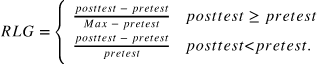

[1] M. Sangin, G. Molinari, M.-A. Nüssli, and P. Dillenbourg, “Facilitating peer knowledge modeling: Effects of a knowledge awareness tool on collaborative learning outcomes and processes,” Computers in Human Behavior, vol. 27, no. 3, pp. 1059–1067, May 2011, doi: 10.1016/j.chb.2010.05.032.

In [ ]:


# Compute the relative learning gain per participant.
for participant in ['A', 'B']:
    l = list()
    for team_no in pretest_df.index:
        pre = pretest_df.loc[team_no, '{}_score'.format(participant)]
        post = posttest_df.loc[team_no, '{}_score'.format(participant)]
        if post > pre:
            v = 1.0 * (post - pre) / (1 - pre)
        else:
            v = 1.0 * (post - pre) / pre
        l.append(v)

    # [(post - pre)/(1-pre) if post > pre else (post - pre)/pre]
    learning_df['{}_RLG'.format(participant)] = l